# data_preparation


## 1. Importing Libraries

In this section, we import the necessary libraries for file management, downloading datasets from Kaggle, and handling data structures. We also include __tqdm__ to monitor the progress of long-running operations.

In [22]:
import kagglehub
import shutil
import os
from pathlib import Path
import csv
from tqdm import tqdm

## 2. Downloading the Dataset

This step involves fetching the FERPlus dataset using kagglehub. The code includes a retry mechanism that attempts the download up to 10 times in case of network interruptions. Once downloaded, the data is moved to a local data directory within the project structure.

In [9]:
destination = Path.cwd().parent / "data"

for i in range(10):
    try:
        path = kagglehub.dataset_download("arnabkumarroy02/ferplus")
        break
    except Exception:
        time.sleep(5)
else:
    raise Exception("Download failed after multiple attempts")

if destination.exists():
    shutil.rmtree(destination)

shutil.move(str(path), str(destination))

print(destination)

  6%|████▊                                                                         | 30.0M/487M [00:10<02:37, 3.04MB/s]


Resuming download from 31457280 bytes (479139832 bytes left)...
Resuming download to C:\Users\Asus\.cache\kagglehub\datasets\arnabkumarroy02\ferplus\3.archive (31457280/510597112) bytes left.


  9%|██████▉                                                                       | 43.0M/487M [00:05<03:00, 2.58MB/s]


Resuming download from 45088768 bytes (465508344 bytes left)...
Resuming download to C:\Users\Asus\.cache\kagglehub\datasets\arnabkumarroy02\ferplus\3.archive (45088768/510597112) bytes left.


 16%|████████████▋                                                                 | 79.0M/487M [00:13<02:31, 2.82MB/s]


Resuming download from 82837504 bytes (427759608 bytes left)...
Resuming download to C:\Users\Asus\.cache\kagglehub\datasets\arnabkumarroy02\ferplus\3.archive (82837504/510597112) bytes left.


 20%|███████████████▊                                                              | 99.0M/487M [00:09<03:12, 2.11MB/s]


Resuming download from 103809024 bytes (406788088 bytes left)...
Resuming download to C:\Users\Asus\.cache\kagglehub\datasets\arnabkumarroy02\ferplus\3.archive (103809024/510597112) bytes left.


100%|███████████████████████████████████████████████████████████████████████████████| 487M/487M [02:05<00:00, 3.24MB/s]

Extracting files...


D:\HW\AI_project\main_project\Facial-Expression-Recognition\data


## 3. Organizing Data and Generating CSV

Here, we scan the downloaded images and organize them. The script renames each image to include its emotion label, moves all files into a single directory, and generates a dataset.csv file. This CSV maps each filename to its corresponding emotion and numerical ID (e.g., Happy = 3, Sad = 4).

In [14]:
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
data_dir = os.path.join(project_root, 'data')
csv_file_dir = os.path.join(project_root, 'CSV files')
csv_file = os.path.join(csv_file_dir, 'dataset.csv')

emotion_mapping = {
    'angry': 0, 'anger': 0,
    'disgust': 1, 'disgusted': 1,
    'fear': 2, 'fearful': 2,
    'happy': 3, 'happiness': 3,
    'sad': 4, 'sadness': 4,
    'surprise': 5, 'suprise': 5,
    'neutral': 6, 'neutrality': 6,
    'contempt': 7
}

data_rows = []
files_to_process = []

if os.path.exists(data_dir):
    print(f"Scanning directory: {data_dir}")

    for root, dirs, files in os.walk(data_dir):
        if root == data_dir:
            continue

        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                files_to_process.append((root, filename))

    print(f"Found {len(files_to_process)} images.")

    for root, filename in tqdm(files_to_process, desc="Moving Images"):
        label_name = os.path.basename(root)
        label_id = emotion_mapping.get(label_name.lower(), -1)

        new_filename = f"{label_name}_{filename}"

        src_path = os.path.join(root, filename)
        dst_path = os.path.join(data_dir, new_filename)

        shutil.move(src_path, dst_path)

        data_rows.append([new_filename, label_name, label_id])

    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['filename', 'label', 'label_id'])
        writer.writerows(data_rows)

    print(f"CSV saved at: {csv_file}")

    print("Cleaning up empty directories...")

    for root, dirs, files in os.walk(data_dir, topdown=False):
        for name in dirs:
            folder_path = os.path.join(root, name)
            try:
                os.rmdir(folder_path)
            except OSError:
                pass

    print("Cleanup completed. Only images remain in 'data' folder.")
    print("Process completed successfully.")

else:
    print(f"Directory not found: {data_dir}")

Scanning directory: D:\HW\AI_project\main_project\Facial-Expression-Recognition\data
Found 78293 images.


Moving Images: 100%|████████████████████████████████████████████████████████████| 78293/78293 [02:24<00:00, 542.55it/s]


CSV saved at: D:\HW\AI_project\main_project\Facial-Expression-Recognition\CSV files\dataset.csv
Cleaning up empty directories...
Cleanup completed. Only images remain in 'data' folder.
Process completed successfully.


## 4. Introducing "Dirty" Data for Testing

To simulate real-world data issues and test our cleaning logic, we intentionally corrupt approximately 2% of the dataset. This includes:

- __Missing Values:__ Removing labels or IDs.

- __Typos:__ Introducing spelling errors in emotion names.

- __Noise:__ Inserting invalid IDs or "NaN" values.

In [17]:
import random

random.seed(42)

def make_typo(text):
    if len(text) > 2:
        idx = random.randint(0, len(text) - 1)
        return text[:idx] + text[idx + 1:]
    return text


if os.path.exists(csv_file):
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        fieldnames = reader.fieldnames
        rows = list(reader)

    count = 0
    total_rows = len(rows)

    for row in rows:
        if random.random() < 0.02:
            count += 1
            error = random.choice(['missing', 'typo', 'bad_id', 'noise'])

            if error == 'missing':
                if random.random() < 0.5:
                    row['label'] = ""
                else:
                    row['label_id'] = ""
            elif error == 'typo':
                row['label'] = make_typo(row['label'])
            elif error == 'bad_id':
                row['label_id'] = random.choice(['99', '-1', '100'])
            elif error == 'noise':
                row['label_id'] = 'NaN'

    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

    print(f"Done! {count} rows (out of {total_rows}) were modified in '{csv_file}'.")

else:
    print(f"Error: File {csv_file_path} not found.")

Done! 1581 rows (out of 78293) were modified in 'D:\HW\AI_project\main_project\Facial-Expression-Recognition\CSV files\dataset.csv'.


## 5. Data Cleaning and Validation

The final step ensures the dataset is reliable for model training. The script validates each row in the CSV by checking for missing values, correcting or removing typos, and verifying that the label_id matches the emotion mapping. The result is saved as dataset_cleaned.csv.

In [18]:
output_csv = os.path.join(csv_file_dir, 'dataset_cleaned.csv')

if os.path.exists(csv_file):
    clean_rows = []
    removed_count = 0
    total_count = 0

    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        fieldnames = reader.fieldnames

        for row in reader:
            total_count += 1
            label = row['label']
            label_id = row['label_id']

            is_valid = True

            if not label or not label_id:
                is_valid = False
            elif label.lower() not in emotion_mapping:
                is_valid = False
            else:
                try:
                    lid = int(label_id)
                    expected_id = emotion_mapping[label.lower()]

                    if lid != expected_id:
                        is_valid = False
                except ValueError:
                    is_valid = False

            if is_valid:
                clean_rows.append(row)
            else:
                removed_count += 1

    with open(output_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(clean_rows)

    print(f"Total rows processed: {total_count}")
    print(f"Rows removed: {removed_count}")
    print(f"Rows kept: {len(clean_rows)}")
    print(f"Cleaned data saved to: {output_csv}")

else:
    print(f"File not found: {csv_file}")

Total rows processed: 78293
Rows removed: 1581
Rows kept: 76712
Cleaned data saved to: D:\HW\AI_project\main_project\Facial-Expression-Recognition\CSV files\dataset_cleaned.csv


## 6. Final Verification and Data Preview

To conclude the data preparation phase, we load the processed dataset into a Pandas DataFrame to verify the results. This step allows us to inspect the first few rows of our cleaned CSV, ensuring that the formatting is correct and that the labels and IDs are properly aligned before moving on to the analysis and modeling stages.

In [21]:
import pandas as pd
df = pd.read_csv(output_csv)
print(df.head(5))

               filename  label  label_id
0  angry_fer0032225.png  angry         0
1  angry_fer0032228.png  angry         0
2  angry_fer0032239.png  angry         0
3  angry_fer0032242.png  angry         0
4  angry_fer0032258.png  angry         0


To ensure the data preparation was successful and the labels accurately represent the images, we can visualize a random sample from the cleaned dataset. This step provides a quick sanity check of the image-to-label mapping

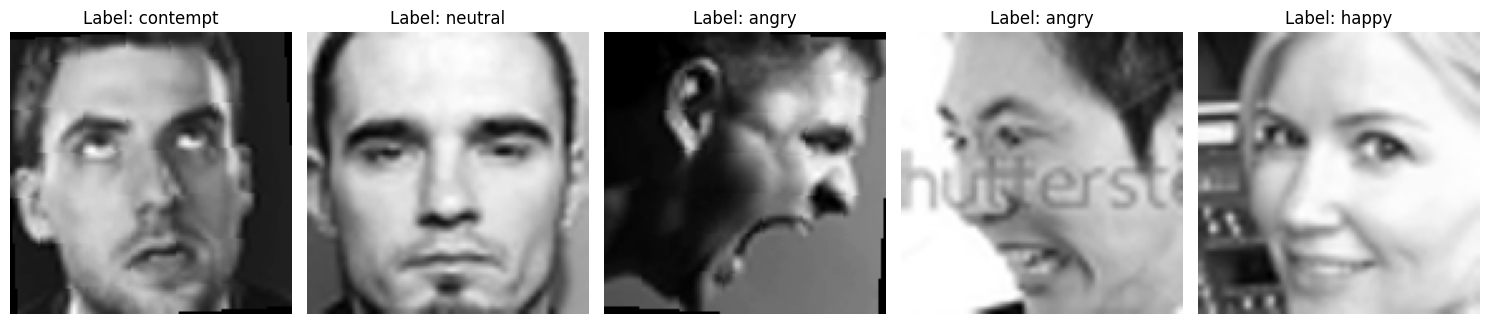

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_df = df.sample(5)

plt.figure(figsize=(15, 5))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(data_dir, row['filename'])
    img = mpimg.imread(img_path)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {row['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()